# Analysis of the Best Bounds

In this notebook, we now analyze the performance of the different experiment-wares (in this case, MIP solvers) in terms of the (intermediate) best bounds they found.
More precisely, we compare the solvers based on the best values they can find, and how fast they find them.

## Imports

As usual, we start by importing the needed classes and constants from *Metrics-Wallet*.

In [1]:
from metrics.wallet import BasicAnalysis, OptiAnalysis
from metrics.wallet.analysis import EXPERIMENT_INPUT

## Loading the data of the experiments

In a [dedicated notebook](load_experiments.ipynb), we already read and preprocessed the data collected during our experiments.
We can now simply reload the cached `BasicAnalysis` to retrieve it.

In [2]:
basic_analysis = BasicAnalysis.import_from_file('.cache')

For the purpose of an optimization analysis, we need to provide an additional *sampling* parameter.
This sampling allows to divide the runtime of the solvers in different steps, and to identify for each solver the best bound it has found at this step.

In [3]:
timeout = 1200
n_samples = 200
sampling = list(range(1, timeout, timeout // n_samples))

Since we now want to perform a more specific analysis, we need to create an `OptiAnalysis` from the `BasicAnalysis`, to get methods that are dedicated to the analysis of the bounds found by optimization solvers.

In [4]:
analysis = OptiAnalysis(basic_analysis=basic_analysis, samp=sampling)

## Focus on *SCIP*

As discussed in the notebook in which we loaded our experiment data, we do not have all the intermediated bounds that *CPLEX* found during its execution.
As such, we cannot make the analysis for *CPLEX*.
We thus focus on the results of *SCIP* in the rest of this notebook.

In [5]:
analysis = analysis.keep_experiment_wares(['$SCIP_{default}$', '$SCIP_{barrier}$', '$SCIP_{barrier-crossover}$'])

## Score computations

We now need to compute various scores for the solvers we ran.
We consider here the default scoring schemes provided by *Metrics*, namely:

+ `optimality`, which is equal to 1 if the solver has found an optimal bound, and 0 otherwise,
+ `dominance`, which is equal to 1 if the current bound is the best bound found so far for this input,
+ `norm_bound`, which is the normalization of the current bound, based on the current minimum and maximum values found for this input, and
+ `borda`, which is based on the Borda count method, and obtained by rating each solver for a given input.

But before doing so, we observed that the instance `/home/cril/wwf/Benchmarks/MILP/enlight_hard.mps.gz` is always solved immediately by all the solvers, without any intermediate bound.
We need to remove it from the analysis, as this causes failures in the scoring methods we use.

In [6]:
analysis = analysis.filter_analysis(lambda xp: xp[EXPERIMENT_INPUT] != '/home/cril/wwf/Benchmarks/MILP/enlight_hard.mps.gz')

Let us now compute the scores of the solvers.
This computation is made **for each input**, by rating the intermediate bounds found by **all the solvers** considered in the analysis.

In [7]:
analysis.compute_scores()

## Plots

Now that we have computed the scores of the solvers for each input, we can draw the corresponding plots.
They provide, for each solver, an aggregated view of the evolution of the quality of the bounds they found w.r.t. their runtime and the other solvers.

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Evolution of optimality scores'}, xlabel='Time (s)', ylabel='Optimality score'>)

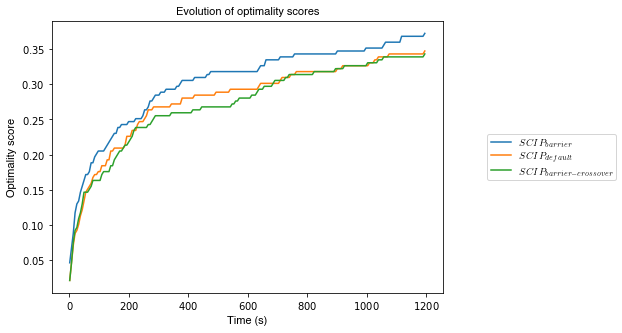

In [8]:
analysis.opti_line_plot(
    col='optimality',
    show_marker=False,

    title='Evolution of optimality scores',
    x_axis_name='Time (s)',
    y_axis_name='Optimality score',

    latex_writing=True,
)

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Evolution of dominance scores'}, xlabel='Time (s)', ylabel='Dominance score'>)

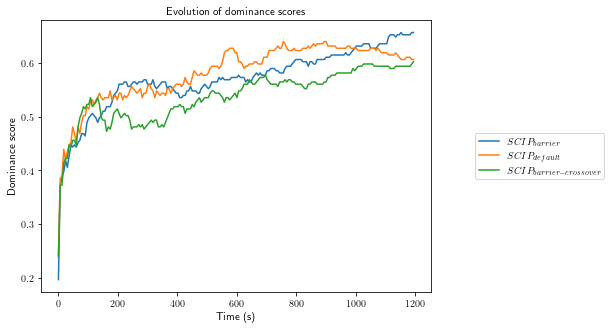

In [9]:
analysis.opti_line_plot(
    col='dominance',
    show_marker=False,

    title='Evolution of dominance scores',
    x_axis_name='Time (s)',
    y_axis_name='Dominance score',

    latex_writing=True,
)

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Evolution of normalized bounds'}, xlabel='Time (s)', ylabel='Normalized bound'>)

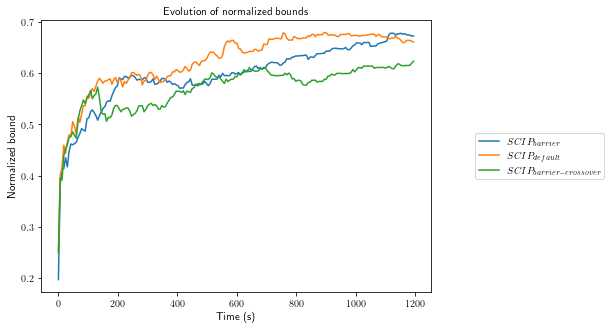

In [10]:
analysis.opti_line_plot(
    col='norm_bound',
    show_marker=False,

    title='Evolution of normalized bounds',
    x_axis_name='Time (s)',
    y_axis_name='Normalized bound',

    latex_writing=True,
)

(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Evolution of Borda scores'}, xlabel='Time (s)', ylabel='Borda score'>)

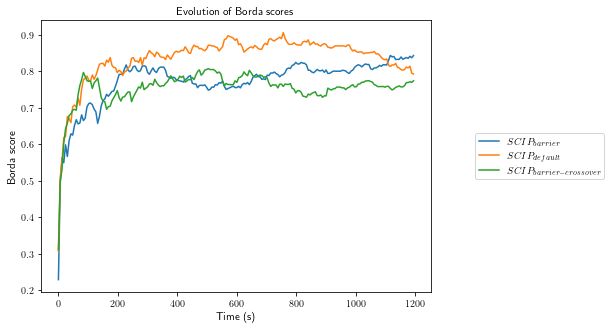

In [11]:
analysis.opti_line_plot(
    col='borda',
    show_marker=False,

    title='Evolution of Borda scores',
    x_axis_name='Time (s)',
    y_axis_name='Borda score',

    latex_writing=True,
)

Let us describe how to read this plot.
At a given time, for instance 800 seconds, we can see that the *barrier-crossover* version of *SCIP* has an average Borda score slightly above 0.7, while it is close to 0.8 for the *barrier* version and close to 0.9 for the *default* version.
This means that, in average and at this point in time, the *default* version has a better rank w.r.t. the Borda scoring method.

We can thus conclude that, most of the time, the *default* version of *SCIP* dominates the others, but when we get close to the timeout, we can observe that the *barrier* version finally dominates.